In [1]:
import os
print(os.getcwd())

d:\HW Year 2\BIC\BIC_Coursework\experiments


# Test ANN Forward Pass

In [2]:
import os, sys
sys.path.append(os.path.abspath(".."))

In [3]:
import numpy as np
from ann.network import ANN
from coupling.utils import flatten_params, unflatten_params

In [ ]:
# To build a small ANN with 8 inputs, 16 hidden (ReLU), 1 output (linear)
net = ANN([8, 16, 1], ["relu", "linear"], seed=0)

# To generate a random input sample
x = np.random.rand(8, 1)

# To perform a forward pass
y = net.forward(x)

print("Output shape:", y.shape)
print("Output value:", y.item())


Output shape: (1, 1)
Output value: 0.07488727562310293


In [ ]:
# To visualise activations at each layer
def forward_visual(net, x):
    a = x
    for i, (W, b, act_name) in enumerate(zip(net.weights, net.biases, net.activations)):
        z = W @ a + b
        a = net.act(z, act_name)
        print(f"Layer {i+1} ({act_name}) output range: [{a.min():.4f}, {a.max():.4f}]")
    return a

forward_visual(net, x)

Layer 1 (relu) output range: [0.0000, 0.2589]
Layer 2 (linear) output range: [0.0749, 0.0749]


array([[0.07488728]])

# Load Dataset

In [ ]:
from experiments.data_utils import load_concrete

# To load data (70/30 split)
Xtr, ytr, Xte, yte, (x_mean, x_std), _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)
print("Train:", Xtr.shape, ytr.shape)
print("Test :", Xte.shape, yte.shape)


Train: (721, 8) (721, 1)
Test : (309, 8) (309, 1)


In [7]:
import numpy as np
print("Train mean ~0:", np.round(Xtr.mean(axis=0), 4))
print("Train std  ~1:", np.round(Xtr.std(axis=0), 4))

Train mean ~0: [-0.  0.  0.  0. -0. -0.  0. -0.]
Train std  ~1: [1. 1. 1. 1. 1. 1. 1. 1.]


# Random Weights Baseline MAE

In [ ]:
from ann.network import ANN
from experiments.predict import predict_batch
from experiments.metrics import mae

# To build a small ANN for regression
net = ANN([8, 16, 1], ["relu", "linear"], seed=0)                   # Simple regression net
y_pred = predict_batch(net, Xte)
print("Random-weights Test MAE:", mae(yte, y_pred))

Random-weights Test MAE: 34.86211828854752


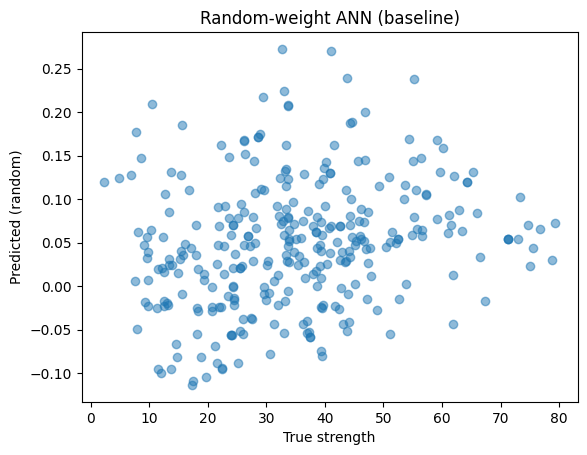

In [9]:
import matplotlib.pyplot as plt

# Scatter plot of true vs predicted
plt.scatter(yte, y_pred, alpha=0.5)
plt.xlabel("True strength"); plt.ylabel("Predicted (random)")
plt.title("Random-weight ANN (baseline)"); plt.show()


# PSO Functionality Test (Sphere Benchmark)

In [ ]:
from pso.pso import PSO
import numpy as np

# A simple sphere function f(x) = Σx² (minimum = 0 at x=0)
def sphere(x): 
    return float(np.sum(x*x))

# To create PSO instance
pso = PSO(swarm_size=10, dim=5, bounds=(-5,5), k_informants=3, seed=0)
pso.init_swarm(sphere)

print("Initial global best (gbest) value:", pso.gbest_val)

# To run 20 steps
for it in range(20):
    pso.step(sphere)

print("Global best after 20 steps:", pso.gbest_val)

Initial global best (gbest) value: 39.65255357793565
Global best after 20 steps: 0.2840603311935848


# PSO–ANN Coupling and Training (Regression Task)

In [17]:
import importlib, pso.pso
importlib.reload(pso.pso)
from pso.pso import PSO

# Boundary hit check

In [ ]:
from pso.pso import PSO
import numpy as np

# A simple toy fitness function
def toy_fit(x): return float(np.sum(x*x))

p = PSO(swarm_size=1, dim=3, bounds=(-1,1), k_informants=1, seed=0)  # k=1
p.init_swarm(toy_fit)

prt = p.particles[0]
prt.pos = np.array([0.95, -0.95, 0.0])
prt.vel = np.array([1.0, -1.0, 0.0])                                 # will cross bounds

p.step(toy_fit)

print("pos after step:", prt.pos)                                    # should be inside [-1,1]
print("vel after step:", prt.vel)                                    # should be flipped on hit if reflect is active

pos after step: [ 0.12178456 -0.54869585 -0.74937638]
vel after step: [-0.82821544  0.40130415 -0.74937638]


# PSO–ANN training: ANN Architecture Experiments with ANN Architecture [8,16,1]

Param dim: 161
Iter  10 | best train MAE = 29.258
Iter  20 | best train MAE = 28.376
Iter  30 | best train MAE = 27.101
Iter  40 | best train MAE = 26.300
Iter  50 | best train MAE = 25.012
Iter  60 | best train MAE = 24.971
Iter  70 | best train MAE = 23.404
Iter  80 | best train MAE = 22.913
Iter  90 | best train MAE = 22.820
Iter 100 | best train MAE = 21.491
Iter 110 | best train MAE = 21.400
Iter 120 | best train MAE = 20.699
Iter 130 | best train MAE = 20.561
Iter 140 | best train MAE = 20.001
Iter 150 | best train MAE = 19.717
Train MAE: 19.717
Test  MAE: 18.504


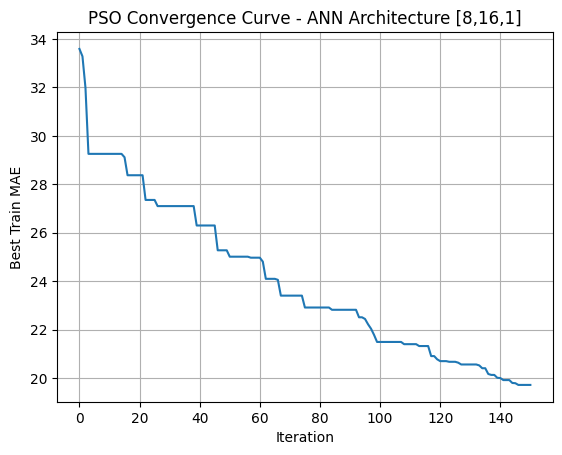

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae
import matplotlib.pyplot as plt

# 1) To load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 16, 1]
acts = ["relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) PSO settings
swarm = 30
iters = 150
bounds = (-1.0, 1.0)

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.729, c1=1.494, c2=1.494, k_informants=3, seed=1
)

# 6) To run PSO optimisation
pso.init_swarm(fitness)
history = [pso.gbest_val]
for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best train MAE = {pso.gbest_val:.3f}")

# 7) To evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

# 8) PSO Learning Curve Plot (Train MAE vs Iterations)
iters_axis = np.arange(len(history))

plt.plot(iters_axis, history)
plt.xlabel("Iteration")
plt.ylabel("Best Train MAE")
plt.title("PSO Convergence Curve - ANN Architecture [8,16,1]")
plt.grid(True)
plt.show()

# ANN Architecture [8,32,1] (Larger single hidden layer)

Param dim: 321
Iter  10 | best train MAE = 27.679
Iter  20 | best train MAE = 26.403
Iter  30 | best train MAE = 24.648
Iter  40 | best train MAE = 24.292
Iter  50 | best train MAE = 23.444
Iter  60 | best train MAE = 21.694
Iter  70 | best train MAE = 20.793
Iter  80 | best train MAE = 19.682
Iter  90 | best train MAE = 18.847
Iter 100 | best train MAE = 18.694
Iter 110 | best train MAE = 18.212
Iter 120 | best train MAE = 18.117
Iter 130 | best train MAE = 17.309
Iter 140 | best train MAE = 16.430
Iter 150 | best train MAE = 16.188
Train MAE: 16.188
Test  MAE: 15.118


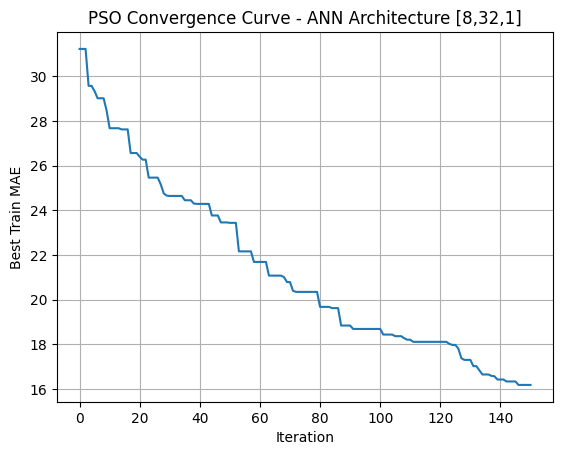

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae

# 1) Load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 32, 1]
acts = ["relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) PSO settings
swarm = 30
iters = 150
bounds = (-1.0, 1.0)

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.729, c1=1.494, c2=1.494, k_informants=3, seed=1
)

# 6) To run PSO optimisation
pso.init_swarm(fitness)
history = [pso.gbest_val]
for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best train MAE = {pso.gbest_val:.3f}")

# 7) To evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

# 8) To plot PSO Learning Curve (Train MAE vs Iterations)
iters_axis = np.arange(len(history))

plt.plot(iters_axis, history)
plt.xlabel("Iteration")
plt.ylabel("Best Train MAE")
plt.title("PSO Convergence Curve - ANN Architecture [8,32,1]")
plt.grid(True)
plt.show()

# ANN Architecture [8,16,8,1] (Two hidden layers)

Param dim: 289
Iter  10 | best train MAE = 27.804
Iter  20 | best train MAE = 25.432
Iter  30 | best train MAE = 23.585
Iter  40 | best train MAE = 23.585
Iter  50 | best train MAE = 22.457
Iter  60 | best train MAE = 18.666
Iter  70 | best train MAE = 18.666
Iter  80 | best train MAE = 18.489
Iter  90 | best train MAE = 16.558
Iter 100 | best train MAE = 16.227
Iter 110 | best train MAE = 15.488
Iter 120 | best train MAE = 15.339
Iter 130 | best train MAE = 14.785
Iter 140 | best train MAE = 14.759
Iter 150 | best train MAE = 13.367
Train MAE: 13.367
Test  MAE: 12.801


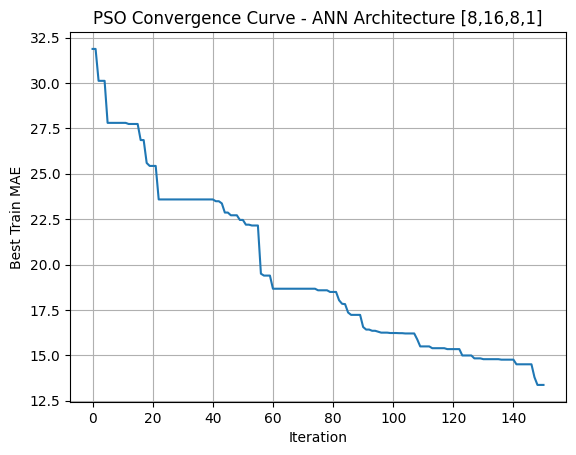

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae

# 1)  To load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 16, 8, 1]                            # Two hidden layers
acts = ["relu", "relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) PSO settings
swarm = 30
iters = 150
bounds = (-1.0, 1.0)

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.729, c1=1.494, c2=1.494, k_informants=3, seed=1
)

# 6) To run PSO optimisation
pso.init_swarm(fitness)
history = [pso.gbest_val]
for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best train MAE = {pso.gbest_val:.3f}")

# 7) To evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

# 8) To plot PSO Learning Curve (Train MAE vs Iterations)
iters_axis = np.arange(len(history))

plt.plot(iters_axis, history)
plt.xlabel("Iteration")
plt.ylabel("Best Train MAE")
plt.title("PSO Convergence Curve - ANN Architecture [8,16,8,1]")
plt.grid(True)
plt.show()

# PSO design experiment - boundary widening (-2, 2)

Param dim: 289
Iter  10 | best train MAE = 16.568
Iter  20 | best train MAE = 13.229
Iter  30 | best train MAE = 12.681
Iter  40 | best train MAE = 12.633
Iter  50 | best train MAE = 12.173
Iter  60 | best train MAE = 11.499
Iter  70 | best train MAE = 11.261
Iter  80 | best train MAE = 11.186
Iter  90 | best train MAE = 10.372
Iter 100 | best train MAE = 10.354
Iter 110 | best train MAE = 10.354
Iter 120 | best train MAE = 9.942
Iter 130 | best train MAE = 9.942
Iter 140 | best train MAE = 9.785
Iter 150 | best train MAE = 9.728
Train MAE: 9.728
Test  MAE: 9.998


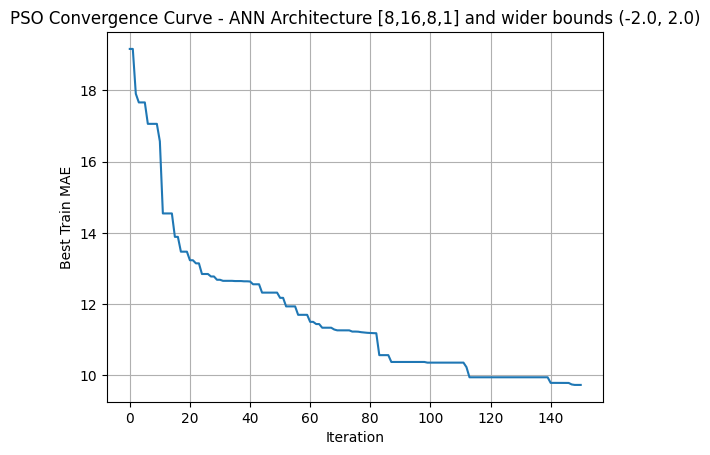

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae

# 1) To load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 16, 8, 1]
acts = ["relu", "relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) PSO settings
swarm = 30
iters = 150
bounds = (-2.0, 2.0)                                                                # Wider bounds

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.729, c1=1.494, c2=1.494, k_informants=3, seed=1
)

# 6) To run PSO optimisation
pso.init_swarm(fitness)
history = [pso.gbest_val]
for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best train MAE = {pso.gbest_val:.3f}")

# 7) To evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

# 8) To plot PSO Learning Curve (Train MAE vs Iterations)
iters_axis = np.arange(len(history))

plt.plot(iters_axis, history)
plt.xlabel("Iteration")
plt.ylabel("Best Train MAE")
plt.title("PSO Convergence Curve - ANN Architecture [8,16,8,1] and wider bounds (-2.0, 2.0)")
plt.grid(True)
plt.show()

# PSO Hyperparameter Tuning — Varying Inertia (w) , Acceleration Coefficients (c1, c2) and Informant count (k_informants)

Param dim: 289
Iter  10 | best train MAE = 12.146
Iter  20 | best train MAE = 10.768
Iter  30 | best train MAE = 10.430
Iter  40 | best train MAE = 10.364
Iter  50 | best train MAE = 9.956
Iter  60 | best train MAE = 9.766
Iter  70 | best train MAE = 9.699
Iter  80 | best train MAE = 9.688
Iter  90 | best train MAE = 9.673
Iter 100 | best train MAE = 9.630
Iter 110 | best train MAE = 9.463
Iter 120 | best train MAE = 9.457
Iter 130 | best train MAE = 9.386
Iter 140 | best train MAE = 9.281
Iter 150 | best train MAE = 9.101
Train MAE: 9.101
Test  MAE: 9.575


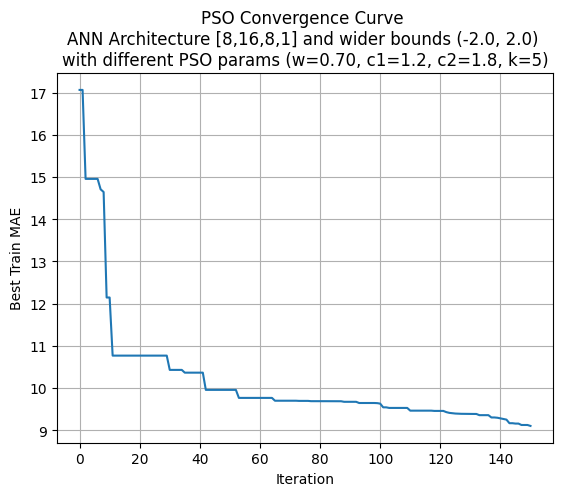

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae

# 1) To Load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 16, 8, 1]
acts = ["relu", "relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) PSO settings
swarm = 30
iters = 150
bounds = (-2.0, 2.0)

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.70, c1=1.2, c2=1.8, k_informants=5, seed=1                  # Different fferent hyperparams
)

# 6) To run PSO optimisation
pso.init_swarm(fitness)
history = [pso.gbest_val]
for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best train MAE = {pso.gbest_val:.3f}")

# 7) To evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

# 8) PSO Learning Curve Plot (Train MAE vs Iterations)
iters_axis = np.arange(len(history))

plt.plot(iters_axis, history)
plt.xlabel("Iteration")
plt.ylabel("Best Train MAE")
plt.title("PSO Convergence Curve \nANN Architecture [8,16,8,1] and wider bounds (-2.0, 2.0) \nwith different PSO params (w=0.70, c1=1.2, c2=1.8, k=5)")
plt.grid(True)
plt.show()

# PSO Evaluation Allocation Test - Changing Swarm size and iteration (50 x 90) with fixed evaluation of 4500

Param dim: 289
Iter  10 | best train MAE = 14.034
Iter  20 | best train MAE = 13.578
Iter  30 | best train MAE = 12.286
Iter  40 | best train MAE = 12.238
Iter  50 | best train MAE = 11.859
Iter  60 | best train MAE = 11.300
Iter  70 | best train MAE = 11.270
Iter  80 | best train MAE = 11.263
Iter  90 | best train MAE = 10.692
Train MAE: 10.692
Test  MAE: 10.317


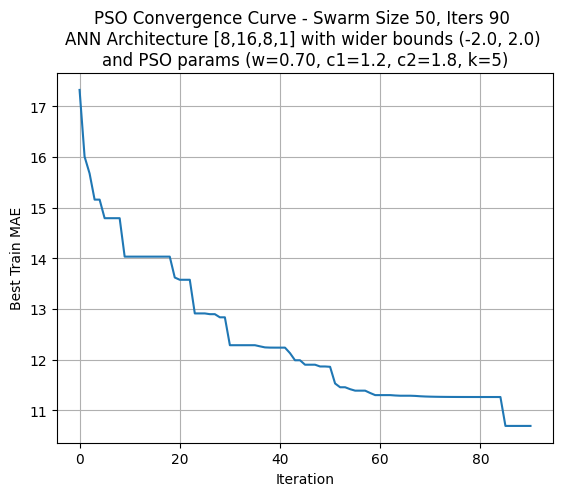

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae

# 1) To load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 16, 8, 1]
acts = ["relu", "relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) PSO settings
swarm = 50
iters = 90
bounds = (-2.0, 2.0)

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.70, c1=1.2, c2=1.8, k_informants=5, seed=1
)

# 6) To run PSO optimisation
pso.init_swarm(fitness)
history = [pso.gbest_val]
for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best train MAE = {pso.gbest_val:.3f}")

# 7) To evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

# 8) To plot PSO Learning Curve (Train MAE vs Iterations)
iters_axis = np.arange(len(history))

plt.plot(iters_axis, history)
plt.xlabel("Iteration")
plt.ylabel("Best Train MAE")
plt.title("PSO Convergence Curve - Swarm Size 50, Iters 90 \nANN Architecture [8,16,8,1] with wider bounds (-2.0, 2.0) \nand PSO params (w=0.70, c1=1.2, c2=1.8, k=5)")
plt.grid(True)
plt.show()

# PSO Evaluation Allocation Test - Changing Swarm size and iteration (10 x 450) with fixed evaluation of 4500

Param dim: 289
Iter  10 | best train MAE = 13.441
Iter  20 | best train MAE = 13.441
Iter  30 | best train MAE = 13.347
Iter  40 | best train MAE = 12.295
Iter  50 | best train MAE = 11.682
Iter  60 | best train MAE = 11.682
Iter  70 | best train MAE = 11.150
Iter  80 | best train MAE = 11.039
Iter  90 | best train MAE = 10.690
Iter 100 | best train MAE = 10.477
Iter 110 | best train MAE = 10.389
Iter 120 | best train MAE = 10.148
Iter 130 | best train MAE = 10.114
Iter 140 | best train MAE = 10.029
Iter 150 | best train MAE = 9.888
Iter 160 | best train MAE = 9.713
Iter 170 | best train MAE = 9.262
Iter 180 | best train MAE = 9.253
Iter 190 | best train MAE = 9.059
Iter 200 | best train MAE = 9.052
Iter 210 | best train MAE = 8.984
Iter 220 | best train MAE = 8.806
Iter 230 | best train MAE = 8.801
Iter 240 | best train MAE = 8.744
Iter 250 | best train MAE = 8.555
Iter 260 | best train MAE = 8.506
Iter 270 | best train MAE = 8.405
Iter 280 | best train MAE = 8.293
Iter 290 | best tra

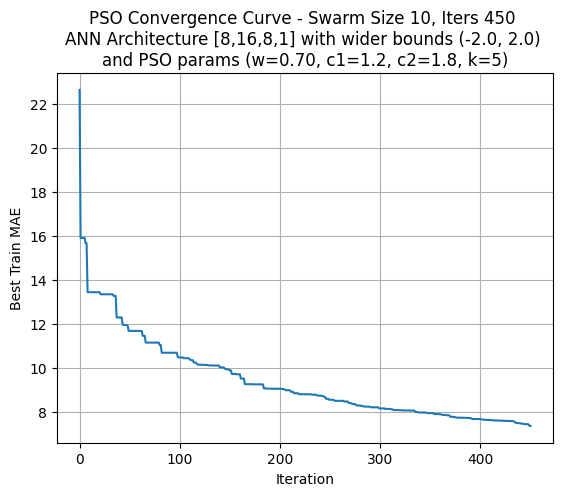

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae

# 1) To Load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 16, 8, 1]
acts = ["relu", "relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) To define PSO settings
swarm = 10
iters = 450
bounds = (-2.0, 2.0)

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.70, c1=1.2, c2=1.8, k_informants=5, seed=1
)

# 6) To run PSO optimisation
pso.init_swarm(fitness)
history = [pso.gbest_val]
for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best train MAE = {pso.gbest_val:.3f}")

# 7) Evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

# 8) PSO Learning Curve Plot (Train MAE vs Iterations)
iters_axis = np.arange(len(history))

plt.plot(iters_axis, history)
plt.xlabel("Iteration")
plt.ylabel("Best Train MAE")
plt.title("PSO Convergence Curve - Swarm Size 10, Iters 450 \nANN Architecture [8,16,8,1] with wider bounds (-2.0, 2.0) \nand PSO params (w=0.70, c1=1.2, c2=1.8, k=5)")
plt.grid(True)
plt.show()

# Validation-Based Early Stopping

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params
from ann.network import ANN
from pso.pso import PSO
from experiments.predict import predict_batch
from experiments.metrics import mae

# 1) To load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

# 2) Architecture (regression - linear output)
arch = [8, 16, 8, 1]
acts = ["relu", "relu", "linear"]

# 3) To build probe ANN to get param dimension
probe = ANN(arch, acts, seed=0)
dim = flatten_params(probe.weights, probe.biases).size
print("Param dim:", dim)

# 4) To define fitness (MAE on training set)
fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=0)

# 5) To define PSO settings
swarm = 10
iters = 450
bounds = (-2.0, 2.0)

pso = PSO(
    swarm_size=swarm, dim=dim, bounds=bounds,
    w=0.70, c1=1.2, c2=1.8, k_informants=5, seed=1
)

# 6) To run PSO optimisation with early stopping
pso.init_swarm(fitness)
history = [pso.gbest_val]
best_val = np.inf
best_vec = None
patience, no_improve = 20, 0           

for t in range(iters):
    pso.step(fitness)
    history.append(pso.gbest_val)
    
    # Early stop check
    if pso.gbest_val < best_val:
        best_val = pso.gbest_val
        best_vec = pso.gbest_pos.copy()
        no_improve = 0
    else:
        no_improve += 1

    if (t+1) % 10 == 0:
        print(f"Iter {t+1:3d} | best val MAE = {pso.gbest_val:.3f}")

    if no_improve >= patience:
        print(f"Early stopping at iter {t+1}")
        break

# To use best_vec for evaluation
from coupling.utils import set_params
set_params(best_net, best_vec)

# 7) To evaluate best on test set
best_vec = pso.gbest_pos
best_net = ANN(arch, acts, seed=0)
from coupling.utils import set_params
set_params(best_net, best_vec)

y_pred_te = predict_batch(best_net, Xte)
y_pred_tr = predict_batch(best_net, Xtr)
print("Train MAE:", f"{mae(ytr, y_pred_tr):.3f}")
print("Test  MAE:", f"{mae(yte, y_pred_te):.3f}")

Param dim: 289
Iter  10 | best val MAE = 13.441
Iter  20 | best val MAE = 13.441
Iter  30 | best val MAE = 13.347
Iter  40 | best val MAE = 12.295
Iter  50 | best val MAE = 11.682
Iter  60 | best val MAE = 11.682
Iter  70 | best val MAE = 11.150
Iter  80 | best val MAE = 11.039
Iter  90 | best val MAE = 10.690
Iter 100 | best val MAE = 10.477
Iter 110 | best val MAE = 10.389
Iter 120 | best val MAE = 10.148
Iter 130 | best val MAE = 10.114
Iter 140 | best val MAE = 10.029
Iter 150 | best val MAE = 9.888
Iter 160 | best val MAE = 9.713
Iter 170 | best val MAE = 9.262
Iter 180 | best val MAE = 9.253
Iter 190 | best val MAE = 9.059
Iter 200 | best val MAE = 9.052
Iter 210 | best val MAE = 8.984
Iter 220 | best val MAE = 8.806
Iter 230 | best val MAE = 8.801
Iter 240 | best val MAE = 8.744
Iter 250 | best val MAE = 8.555
Iter 260 | best val MAE = 8.506
Iter 270 | best val MAE = 8.405
Iter 280 | best val MAE = 8.293
Iter 290 | best val MAE = 8.239
Iter 300 | best val MAE = 8.160
Iter 310 | 

# Stochasticity Analysis — 10-Seed Evaluation

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from ann.network import ANN
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params, set_params
from experiments.predict import predict_batch
from experiments.metrics import mae
from pso.pso import PSO

def run_once(seed):
    #   To load data (fixed split seed for fairness)
    Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)
    # To define architecture
    arch = [8,16,8,1]; acts = ["relu","relu","linear"]
    # To get dimension
    probe = ANN(arch, acts, seed=seed)
    dim = flatten_params(probe.weights, probe.biases).size
    # To define fitness on TRAIN
    fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=seed)
    # To define PSO 
    pso = PSO(swarm_size=10, dim=dim, bounds=(-2.0,2.0),
              w=0.70, c1=1.2, c2=1.8, k_informants=5, seed=seed)
    pso.init_swarm(fitness)
    for _ in range(450):
        pso.step(fitness)

    # To evaluate
    best_net = ANN(arch, acts, seed=seed)
    set_params(best_net, pso.gbest_pos)
    y_tr = predict_batch(best_net, Xtr); y_te = predict_batch(best_net, Xte)
    return (mae(ytr, y_tr), mae(yte, y_te))

# To run 10 times with different seeds
results = [run_once(s) for s in range(10)]
tr = np.array([r[0] for r in results])
te = np.array([r[1] for r in results])

print(f"Train MAE  mean±std: {tr.mean():.3f} ± {tr.std():.3f}")
print(f"Test  MAE  mean±std: {te.mean():.3f} ± {te.std():.3f}")

Train MAE  mean±std: 7.351 ± 0.386
Test  MAE  mean±std: 7.426 ± 0.572


# ANN Architecture Sweep (10-Seed Mean ± Std)
Evaluating different ANN architectures [8, 8, 1], [8, 16, 1], [8, 32, 1], and [8, 16, 8, 1] under identical PSO settings.

Architecture sweep (10 seeds each) — MAE mean ± std
      [8, 8, 1] | Train 8.784 ± 0.204 | Test 9.114 ± 0.246
     [8, 16, 1] | Train 8.370 ± 0.313 | Test 8.544 ± 0.332
     [8, 32, 1] | Train 7.927 ± 0.302 | Test 8.050 ± 0.436
  [8, 16, 8, 1] | Train 7.351 ± 0.386 | Test 7.426 ± 0.572


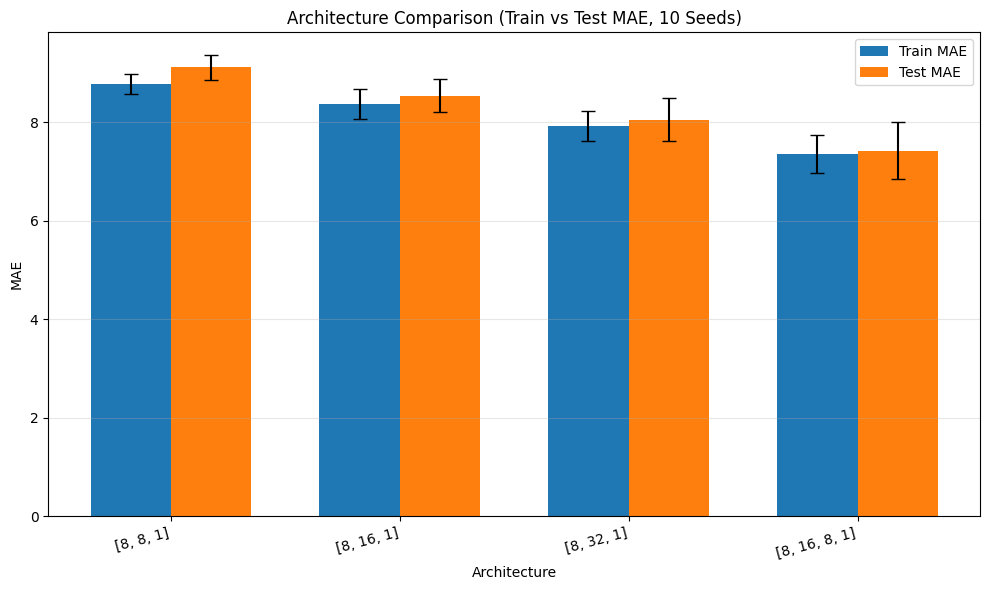

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from ann.network import ANN
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params, set_params
from experiments.predict import predict_batch
from experiments.metrics import mae
from pso.pso import PSO
import matplotlib.pyplot as plt

# To define architectures to test
ARCHES = [
    ([8, 8, 1],        ["relu","linear"]),
    ([8, 16, 1],       ["relu","linear"]),
    ([8, 32, 1],       ["relu","linear"]),
    ([8, 16, 8, 1],    ["relu","relu","linear"]),   # Current best depth
]

# Function to run one experiment for a given architecture and seed
def run_once_arch(arch, acts, seed):
    Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)   # fixed split
    probe = ANN(arch, acts, seed=seed)
    dim = flatten_params(probe.weights, probe.biases).size
    fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=seed)

    # To run PSO
    pso = PSO(
        swarm_size=10, dim=dim, bounds=(-2.0, 2.0),
        w=0.70, c1=1.2, c2=1.8, k_informants=5, seed=seed
    )
    pso.init_swarm(fitness)
    for _ in range(450):     
        pso.step(fitness)

    # To evaluate
    net = ANN(arch, acts, seed=seed)
    set_params(net, pso.gbest_pos)
    y_tr = predict_batch(net, Xtr); y_te = predict_batch(net, Xte)
    return mae(ytr, y_tr), mae(yte, y_te)

# To run experiments
summary = []
for arch, acts in ARCHES:
    tr, te = [], []
    for s in range(10):
        mtr, mte = run_once_arch(arch, acts, s)
        tr.append(mtr); te.append(mte)
    tr = np.array(tr); te = np.array(te)
    summary.append({
        "arch": str(arch),
        "train_mae_mean": float(tr.mean()), "train_mae_std": float(tr.std()),
        "test_mae_mean":  float(te.mean()), "test_mae_std":  float(te.std()),
    })

# To print summary
print("Architecture sweep (10 seeds each) — MAE mean ± std")
for row in summary:
    print(f"{row['arch']:>15} | "
          f"Train {row['train_mae_mean']:.3f} ± {row['train_mae_std']:.3f} | "
          f"Test {row['test_mae_mean']:.3f} ± {row['test_mae_std']:.3f}")

# Architecture comparison plot
# labels for each architecture
arch_labels = [row["arch"] for row in summary]

train_means = [row["train_mae_mean"] for row in summary]
train_stds  = [row["train_mae_std"]  for row in summary]

test_means  = [row["test_mae_mean"]  for row in summary]
test_stds   = [row["test_mae_std"]   for row in summary]

x = np.arange(len(arch_labels))
width = 0.35  # bar width

plt.figure(figsize=(10, 6))

# train bars
plt.bar(x - width/2, train_means, width,
        yerr=train_stds, capsize=5, label="Train MAE")

# test bars
plt.bar(x + width/2, test_means, width,
        yerr=test_stds, capsize=5, label="Test MAE")

plt.xticks(x, arch_labels, rotation=15, ha="right")
plt.ylabel("MAE")
plt.xlabel("Architecture")
plt.title("Architecture Comparison (Train vs Test MAE, 10 Seeds)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Activation Function Comparison (ReLU, tanh, sigmoid, softplus) on [8, 16, 8, 1]

Activation comparison (5 seeds) — MAE mean ± std
relu     | Train 7.351 ± 0.386 | Test 7.426 ± 0.572
tanh     | Train 20.411 ± 0.528 | Test 19.327 ± 0.506
sigmoid  | Train 19.912 ± 0.082 | Test 18.809 ± 0.083
softplus | Train 7.737 ± 0.436 | Test 7.775 ± 0.624


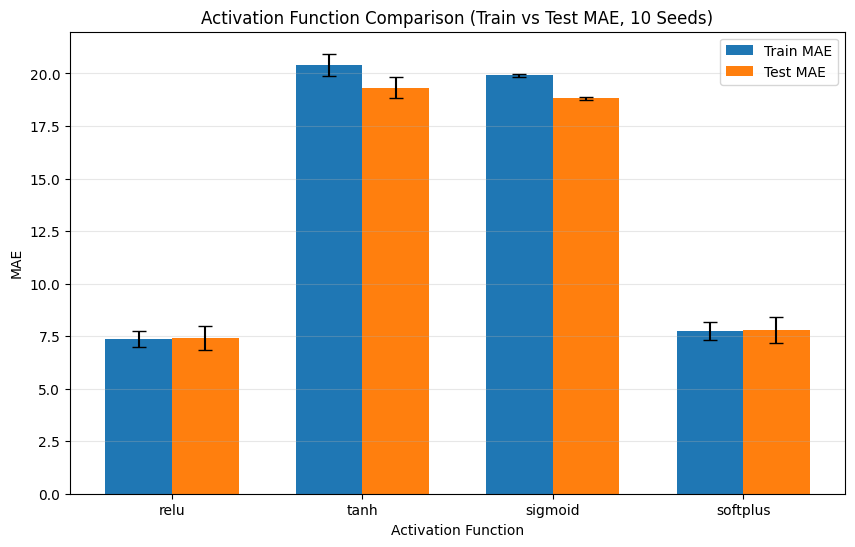

In [ ]:
# Activation function comparison on fixed architecture [8,16,8,1]
import numpy as np
from experiments.data_utils import load_concrete
from ann.network import ANN
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params, set_params
from experiments.predict import predict_batch
from experiments.metrics import mae
from pso.pso import PSO
import matplotlib.pyplot as plt

# List of hidden layer activations to test
ACT_SETS = [
    ("relu",     ["relu",     "relu",     "linear"]),
    ("tanh",     ["tanh",     "tanh",     "linear"]),
    ("sigmoid",  ["sigmoid",  "sigmoid",  "linear"]),
    ("softplus", ["softplus", "softplus", "linear"]),
]

# Function to run one experiment for a given activation set and seed
def run_once_activation(acts, seed):
    # To load data (fixed split)
    Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

    arch = [8, 16, 8, 1]
    net_probe = ANN(arch, acts, seed=seed)
    dim = flatten_params(net_probe.weights, net_probe.biases).size

    fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=seed)

    # To define PSO settings, same hyperparams
    pso = PSO(
        swarm_size=10, dim=dim, bounds=(-2.0, 2.0),
        w=0.70, c1=1.2, c2=1.8, k_informants=5, seed=seed
    )
    pso.init_swarm(fitness)
    for _ in range(450):
        pso.step(fitness)

    # To build final network with best parameters
    best_net = ANN(arch, acts, seed=seed)
    set_params(best_net, pso.gbest_pos)

    y_tr = predict_batch(best_net, Xtr)
    y_te = predict_batch(best_net, Xte)
    return mae(ytr, y_tr), mae(yte, y_te)

# To run a stochastic study with 10 different seeds
seeds = range(10)                                                

# To collect results
summary = []
for name, acts in ACT_SETS:
    tr, te = [], []
    for s in seeds:
        mtr, mte = run_once_activation(acts, s)
        tr.append(mtr); te.append(mte)
    tr = np.array(tr); te = np.array(te)
    summary.append((name, tr.mean(), tr.std(), te.mean(), te.std()))

# To print summary
print("Activation comparison (5 seeds) — MAE mean ± std")
for name, tr_m, tr_s, te_m, te_s in summary:
    print(f"{name:8s} | Train {tr_m:.3f} ± {tr_s:.3f} | Test {te_m:.3f} ± {te_s:.3f}")

# To extract TRAIN means/stds from summary
relu_train_mean, relu_train_std         = summary[0][1], summary[0][2]
tanh_train_mean, tanh_train_std         = summary[1][1], summary[1][2]
sigmoid_train_mean, sigmoid_train_std   = summary[2][1], summary[2][2]
softplus_train_mean, softplus_train_std = summary[3][1], summary[3][2]

# To extract TEST means/stds from summary
relu_test_mean, relu_test_std           = summary[0][3], summary[0][4]
tanh_test_mean, tanh_test_std           = summary[1][3], summary[1][4]
sigmoid_test_mean, sigmoid_test_std     = summary[2][3], summary[2][4]
softplus_test_mean, softplus_test_std   = summary[3][3], summary[3][4]

# To plot activation function comparison
act_labels = ["relu", "tanh", "sigmoid", "softplus"]

train_means = [relu_train_mean, tanh_train_mean, sigmoid_train_mean, softplus_train_mean]
train_stds  = [relu_train_std,  tanh_train_std,  sigmoid_train_std,  softplus_train_std]

test_means = [relu_test_mean, tanh_test_mean, sigmoid_test_mean, softplus_test_mean]
test_stds  = [relu_test_std,  tanh_test_std,  sigmoid_test_std,  softplus_test_std]

x = np.arange(len(act_labels))
width = 0.35

plt.figure(figsize=(10,6))

plt.bar(x - width/2, train_means, width,
        yerr=train_stds, capsize=5, label="Train MAE")

plt.bar(x + width/2, test_means, width,
        yerr=test_stds, capsize=5, label="Test MAE")

plt.xticks(x, act_labels)
plt.ylabel("MAE")
plt.xlabel("Activation Function")
plt.title("Activation Function Comparison (Train vs Test MAE, 10 Seeds)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.show()

# PSO Extension — Encoding Activation Functions Inside the Solution Vector
This lets the swarm choose each hidden layer’s activation (ReLU or Softplus) by encoding simple “activation genes” inside the solution vector

In [ ]:
import numpy as np
from experiments.data_utils import load_concrete
from ann.network import ANN
from coupling.utils import flatten_params, set_params
from experiments.predict import predict_batch
from experiments.metrics import mae
from pso.pso import PSO

# Architecture to test (2 hidden layers)
arch = [8,16,8,1]

# Number of hidden layers = (len(arch)-2)
n_hidden = len(arch) - 2

def decode_activations(act_bits):
    # Decode activation bits into activation names
    acts = []
    for v in act_bits:
        acts.append("relu" if v < 0 else "softplus")
    return acts

def make_ann_fitness_with_activation(Xtr, ytr, arch, seed=0):
    # This fitness encodes both weights/biases and hidden-layer activation choices.
    # The vector structure is: [param_vector , act_bits]
    # Where act_bits has length equal to number of hidden layers.
    
    # To build probe to get parameter dimension
    probe = ANN(arch, ["relu"]*(n_hidden) + ["linear"], seed=seed)
    param_dim = flatten_params(probe.weights, probe.biases).size

    def fitness(vec):
        # Split vector
        params_vec = vec[:param_dim]
        act_bits   = vec[param_dim:]

        # Decode activations
        hidden_acts = decode_activations(act_bits)
        acts = hidden_acts + ["linear"]        # Always linear output

        # Rebuild ANN with chosen activations
        net = ANN(arch, acts, seed=seed)
        set_params(net, params_vec)

        # Evaluate  MAE
        y_pred = predict_batch(net, Xtr)
        return mae(ytr, y_pred)

    return fitness, param_dim

# Load data
Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)

tr_mae, te_mae = [], []

# To run 10 seeds
for s in range(10):
    # Fitness & Dimension
    fitness, param_dim = make_ann_fitness_with_activation(Xtr, ytr, arch, seed=s)

    # Total dimension: params and activation bits
    dim_total = param_dim + n_hidden

    pso = PSO(
        swarm_size=10,
        dim=dim_total,
        bounds=(-2.0, 2.0),
        w=0.70, c1=1.2, c2=1.8,
        k_informants=5,
        seed=s
    )

    # To run PSO
    pso.init_swarm(fitness)
    for _ in range(450):
        pso.step(fitness)

    # To decode the best vector
    best = pso.gbest_pos
    params_vec = best[:param_dim]
    act_bits   = best[param_dim:]
    hidden_acts = decode_activations(act_bits)
    acts = hidden_acts + ["linear"]

    # To build best ANN
    best_net = ANN(arch, acts, seed=s)
    set_params(best_net, params_vec)

    ytr_pred = predict_batch(best_net, Xtr)
    yte_pred = predict_batch(best_net, Xte)

    tr_mae.append(mae(ytr, ytr_pred))
    te_mae.append(mae(yte, yte_pred))

# To print summary
print("Activation-Optimising PSO (10 seeds) — MAE mean ± std")
print(f"Train {np.mean(tr_mae):.3f} ± {np.std(tr_mae):.3f}")
print(f"Test  {np.mean(te_mae):.3f} ± {np.std(te_mae):.3f}")

Activation-Optimising PSO (10 seeds) — MAE mean ± std
Train 7.427 ± 0.440
Test  7.575 ± 0.453


# PSO Hyperparameter Grid Search (10-Seed Mean ± Std)
Exploring the effect of swarm hyperparameters on ANN performance.

PSO parameter sweep (10 seeds) — MAE mean ± std
    w=0.5, c1=1.5, c2=1.5, k=3 | Train 8.320 ± 0.899 | Test 8.497 ± 1.091
    w=0.7, c1=1.2, c2=1.8, k=3 | Train 9.100 ± 0.797 | Test 9.430 ± 0.929
    w=0.7, c1=1.8, c2=1.2, k=3 | Train 8.368 ± 0.798 | Test 8.481 ± 0.719
    w=0.9, c1=1.5, c2=1.5, k=3 | Train 12.996 ± 0.525 | Test 13.287 ± 0.535
    w=0.7, c1=1.2, c2=1.8, k=5 | Train 7.351 ± 0.386 | Test 7.426 ± 0.572


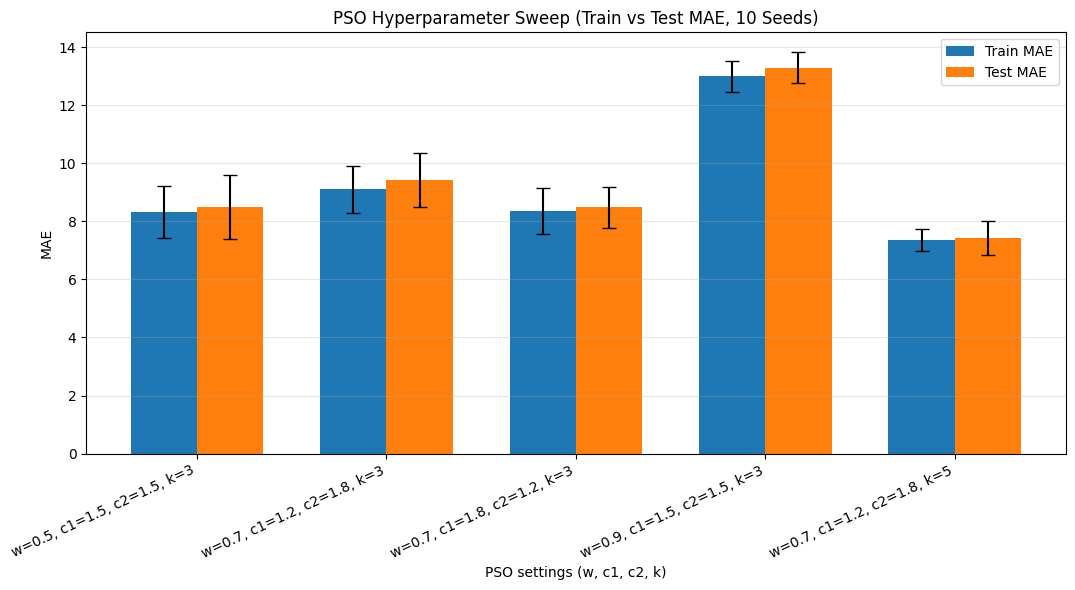

In [4]:
import numpy as np
from experiments.data_utils import load_concrete
from ann.network import ANN
from coupling.fitness import make_ann_fitness
from coupling.utils import flatten_params, set_params
from experiments.predict import predict_batch
from experiments.metrics import mae
from pso.pso import PSO
import matplotlib.pyplot as plt

# fixed best ANN architecture
arch = [8,16,8,1]
acts = ["relu","relu","linear"]

# PSO parameter grid to test
GRID = [
    (0.5, 1.5, 1.5, 3),
    (0.7, 1.2, 1.8, 3),
    (0.7, 1.8, 1.2, 3),
    (0.9, 1.5, 1.5, 3),
    (0.7, 1.2, 1.8, 5),
]

# Function to run one experiment for given PSO parameters and seed
def run_once_pso(w, c1, c2, k, seed):
    Xtr, ytr, Xte, yte, _, _ = load_concrete("../data/concrete.csv", test_ratio=0.3, seed=0)
    probe = ANN(arch, acts, seed=seed)
    dim = flatten_params(probe.weights, probe.biases).size
    fitness = make_ann_fitness(Xtr, ytr, arch, acts, seed=seed)
    pso = PSO(swarm_size=10, dim=dim, bounds=(-2.0,2.0),
              w=w, c1=c1, c2=c2, k_informants=k, seed=seed)
    pso.init_swarm(fitness)
    for _ in range(450):
        pso.step(fitness)
    net = ANN(arch, acts, seed=seed)
    set_params(net, pso.gbest_pos)
    y_tr = predict_batch(net, Xtr); y_te = predict_batch(net, Xte)
    return mae(ytr, y_tr), mae(yte, y_te)

# Run experiments over the grid
results = []
for (w, c1, c2, k) in GRID:
    tr, te = [], []
    for s in range(10):
        mtr, mte = run_once_pso(w, c1, c2, k, s)
        tr.append(mtr); te.append(mte)
    tr = np.array(tr); te = np.array(te)
    results.append({
        "params": f"w={w}, c1={c1}, c2={c2}, k={k}",
        "train_mean": float(tr.mean()), "train_std": float(tr.std()),
        "test_mean":  float(te.mean()), "test_std":  float(te.std()),
    })

# Print summary
print("PSO parameter sweep (10 seeds) — MAE mean ± std")
for r in results:
    print(f"{r['params']:>30} | "
          f"Train {r['train_mean']:.3f} ± {r['train_std']:.3f} | "
          f"Test {r['test_mean']:.3f} ± {r['test_std']:.3f}")

# PSO Hyperparameter comparison plot
param_labels = [r["params"] for r in results]

train_means = [r["train_mean"] for r in results]
train_stds  = [r["train_std"]  for r in results]

test_means  = [r["test_mean"]  for r in results]
test_stds   = [r["test_std"]   for r in results]

x = np.arange(len(param_labels))
width = 0.35

plt.figure(figsize=(11, 6))

plt.bar(x - width/2, train_means, width,
        yerr=train_stds, capsize=5, label="Train MAE")

plt.bar(x + width/2, test_means, width,
        yerr=test_stds, capsize=5, label="Test MAE")

plt.xticks(x, param_labels, rotation=25, ha="right")
plt.ylabel("MAE")
plt.xlabel("PSO settings (w, c1, c2, k)")
plt.title("PSO Hyperparameter Sweep (Train vs Test MAE, 10 Seeds)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()